In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [15]:
torch.manual_seed(1)
batch_size=128

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.2),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1,
                    min_height=16, min_width=16, fill_value=[0,0,0], mask_fill_value=None, p=0.5),
    ToTensorV2()
])

# Test Phase transformations
test_transforms = A.Compose([
    A.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-816878385.py:18: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1,


In [16]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
class AlbumentationsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)  # Convert PIL to NumPy

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [17]:
from torchvision import datasets

base_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
train_dataset = AlbumentationsDataset(base_dataset, transform=train_transforms)

base_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
test_dataset = AlbumentationsDataset(base_dataset, transform=test_transforms)

if use_cuda:
  dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=batch_size)


train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)


In [18]:
class Net(nn.Module):
  def __init__(self, input_size, num_classes):
    dropout_value = 0.1
    super(Net, self).__init__()

    self.convblock1 =  nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) #32x32x16, rf = 3

    self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #32x32x32, rf = 5


    self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2, dilation=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #32x32x64, rf = 9


    self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #30x30x128, rf = 13

    self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #28x28x32, rf = 17

    self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3, 3), padding=0, stride=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Dropout(dropout_value)
        ) #13x13x48, rf = 25

    self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #11x11x64, rf = 33

    self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) #9x9x128, rf = 41

    self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=48, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Dropout(dropout_value)
        ) #7x7x48, rf = 49

    self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) #7x7x10, rf = 49

    #self.fc = nn.Linear(in_features=26x26x64, out_features=num_classes, bias=False)
    self.gap = nn.AvgPool2d(kernel_size=7)

  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.convblock8(x)
    x = self.convblock9(x)
    x = self.convblock10(x)
    x = self.gap(x)
    x = x.view(-1, 10)
    return F.log_softmax(x, dim=-1)

In [19]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(input_size=32, num_classes=10)
model.to(device)
summary(model, input_size=(3, 32, 32))

True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,432
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 30, 30]          73,728
             ReLU-14          [-1,

In [20]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch, scheduler=None):
  model.train()
  pbar = tqdm(train_loader)
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if scheduler is not None:
        scheduler.step()
    train_losses.append(loss.item())
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    processed = len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_acc.append(100. * correct / len(test_loader.dataset))


  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [10]:
!pip install torch_lr_finder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.66E-03


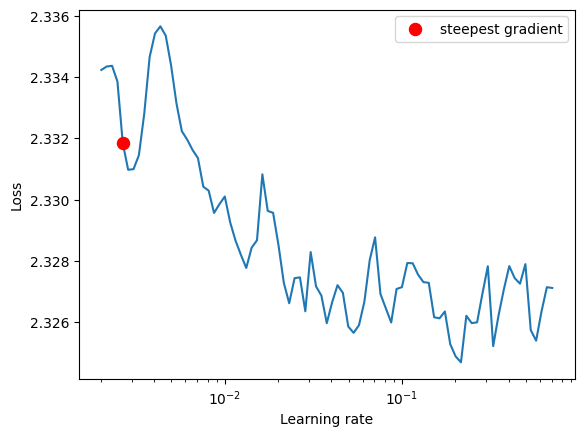

In [21]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

from torch_lr_finder import LRFinder
model = Net(32, 10).to(device)

lr_finder = LRFinder(model, optimizer, criterion=criterion, device=device)
lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot()  # to visualize the loss vs. learning rate
lr_finder.reset() # to restore the model and optimizer to their initial state

In [22]:
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader),
                                          epochs=40, pct_start=0.4, anneal_strategy='cos',div_factor=15)

for epoch in range(40):
  print(epoch+1)
  train(model, device, train_loader, optimizer, epoch, scheduler)
  test(model, device, test_loader)

1


Loss=1.411865234375 Batch_id=390 Accuracy=51.25: 100%|██████████| 391/391 [00:23<00:00, 16.86it/s]



Test set: Average loss: 1.3285, Accuracy: 5250/10000 (52.50%)

2


Loss=1.1944183111190796 Batch_id=390 Accuracy=58.75: 100%|██████████| 391/391 [00:22<00:00, 17.42it/s]



Test set: Average loss: 1.0745, Accuracy: 6273/10000 (62.73%)

3


Loss=1.3828790187835693 Batch_id=390 Accuracy=52.50: 100%|██████████| 391/391 [00:21<00:00, 18.27it/s]



Test set: Average loss: 0.9612, Accuracy: 6619/10000 (66.19%)

4


Loss=0.8216273188591003 Batch_id=390 Accuracy=72.50: 100%|██████████| 391/391 [00:22<00:00, 17.27it/s]



Test set: Average loss: 0.9143, Accuracy: 6858/10000 (68.58%)

5


Loss=0.989568829536438 Batch_id=390 Accuracy=65.00: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]



Test set: Average loss: 0.7812, Accuracy: 7288/10000 (72.88%)

6


Loss=0.8029298782348633 Batch_id=390 Accuracy=72.50: 100%|██████████| 391/391 [00:21<00:00, 18.28it/s]



Test set: Average loss: 0.7438, Accuracy: 7478/10000 (74.78%)

7


Loss=0.9680486917495728 Batch_id=390 Accuracy=68.75: 100%|██████████| 391/391 [00:22<00:00, 17.35it/s]



Test set: Average loss: 0.6901, Accuracy: 7695/10000 (76.95%)

8


Loss=0.615423321723938 Batch_id=390 Accuracy=80.00: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]



Test set: Average loss: 0.7276, Accuracy: 7531/10000 (75.31%)

9


Loss=0.8753268122673035 Batch_id=390 Accuracy=68.75: 100%|██████████| 391/391 [00:21<00:00, 18.21it/s]



Test set: Average loss: 0.6391, Accuracy: 7785/10000 (77.85%)

10


Loss=0.7200003862380981 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:21<00:00, 18.20it/s]



Test set: Average loss: 0.6225, Accuracy: 7917/10000 (79.17%)

11


Loss=0.913820743560791 Batch_id=390 Accuracy=67.50: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]



Test set: Average loss: 0.6509, Accuracy: 7828/10000 (78.28%)

12


Loss=0.8099635243415833 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:21<00:00, 18.16it/s]



Test set: Average loss: 0.5805, Accuracy: 8015/10000 (80.15%)

13


Loss=0.6325650811195374 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:21<00:00, 18.28it/s]



Test set: Average loss: 0.5682, Accuracy: 8080/10000 (80.80%)

14


Loss=0.5589082837104797 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]



Test set: Average loss: 0.5366, Accuracy: 8161/10000 (81.61%)

15


Loss=0.5849014520645142 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:21<00:00, 18.25it/s]



Test set: Average loss: 0.5496, Accuracy: 8093/10000 (80.93%)

16


Loss=0.7636474370956421 Batch_id=390 Accuracy=72.50: 100%|██████████| 391/391 [00:21<00:00, 18.36it/s]



Test set: Average loss: 0.5017, Accuracy: 8304/10000 (83.04%)

17


Loss=0.5829275846481323 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]



Test set: Average loss: 0.5186, Accuracy: 8238/10000 (82.38%)

18


Loss=0.4843538701534271 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:21<00:00, 18.10it/s]



Test set: Average loss: 0.5008, Accuracy: 8288/10000 (82.88%)

19


Loss=0.6785169243812561 Batch_id=390 Accuracy=76.25: 100%|██████████| 391/391 [00:21<00:00, 18.35it/s]



Test set: Average loss: 0.4992, Accuracy: 8317/10000 (83.17%)

20


Loss=0.4937567114830017 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]



Test set: Average loss: 0.4836, Accuracy: 8350/10000 (83.50%)

21


Loss=0.6725547909736633 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:21<00:00, 17.86it/s]



Test set: Average loss: 0.4819, Accuracy: 8372/10000 (83.72%)

22


Loss=0.7370798587799072 Batch_id=390 Accuracy=73.75: 100%|██████████| 391/391 [00:21<00:00, 18.12it/s]



Test set: Average loss: 0.4567, Accuracy: 8471/10000 (84.71%)

23


Loss=0.5275722742080688 Batch_id=390 Accuracy=80.00: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]



Test set: Average loss: 0.4825, Accuracy: 8375/10000 (83.75%)

24


Loss=0.6739963293075562 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:23<00:00, 16.95it/s]



Test set: Average loss: 0.4614, Accuracy: 8457/10000 (84.57%)

25


Loss=0.5300987958908081 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:21<00:00, 18.30it/s]



Test set: Average loss: 0.4467, Accuracy: 8480/10000 (84.80%)

26


Loss=0.6519026756286621 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:22<00:00, 17.52it/s]



Test set: Average loss: 0.4535, Accuracy: 8449/10000 (84.49%)

27


Loss=0.5546606779098511 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]



Test set: Average loss: 0.4306, Accuracy: 8559/10000 (85.59%)

28


Loss=0.7775601744651794 Batch_id=390 Accuracy=72.50: 100%|██████████| 391/391 [00:21<00:00, 18.33it/s]



Test set: Average loss: 0.4250, Accuracy: 8589/10000 (85.89%)

29


Loss=0.49955153465270996 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:22<00:00, 17.46it/s]



Test set: Average loss: 0.4223, Accuracy: 8587/10000 (85.87%)

30


Loss=0.5757825374603271 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:22<00:00, 17.39it/s]



Test set: Average loss: 0.4177, Accuracy: 8612/10000 (86.12%)

31


Loss=0.43415388464927673 Batch_id=390 Accuracy=82.50: 100%|██████████| 391/391 [00:21<00:00, 18.52it/s]



Test set: Average loss: 0.4057, Accuracy: 8614/10000 (86.14%)

32


Loss=0.3464328348636627 Batch_id=390 Accuracy=92.50: 100%|██████████| 391/391 [00:22<00:00, 17.55it/s]



Test set: Average loss: 0.3982, Accuracy: 8658/10000 (86.58%)

33


Loss=0.4208565652370453 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:22<00:00, 17.15it/s]



Test set: Average loss: 0.3922, Accuracy: 8677/10000 (86.77%)

34


Loss=0.32591500878334045 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:21<00:00, 18.36it/s]



Test set: Average loss: 0.3857, Accuracy: 8704/10000 (87.04%)

35


Loss=0.5040775537490845 Batch_id=390 Accuracy=86.25: 100%|██████████| 391/391 [00:21<00:00, 17.79it/s]



Test set: Average loss: 0.3807, Accuracy: 8704/10000 (87.04%)

36


Loss=0.3608524799346924 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]



Test set: Average loss: 0.3784, Accuracy: 8724/10000 (87.24%)

37


Loss=0.5692553520202637 Batch_id=390 Accuracy=80.00: 100%|██████████| 391/391 [00:21<00:00, 18.07it/s]



Test set: Average loss: 0.3731, Accuracy: 8734/10000 (87.34%)

38


Loss=0.35730814933776855 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:21<00:00, 18.11it/s]



Test set: Average loss: 0.3676, Accuracy: 8774/10000 (87.74%)

39


Loss=0.31948795914649963 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]



Test set: Average loss: 0.3653, Accuracy: 8776/10000 (87.76%)

40


Loss=0.41528835892677307 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s]



Test set: Average loss: 0.3690, Accuracy: 8771/10000 (87.71%)



Text(0.5, 1.0, 'Test Accuracy')

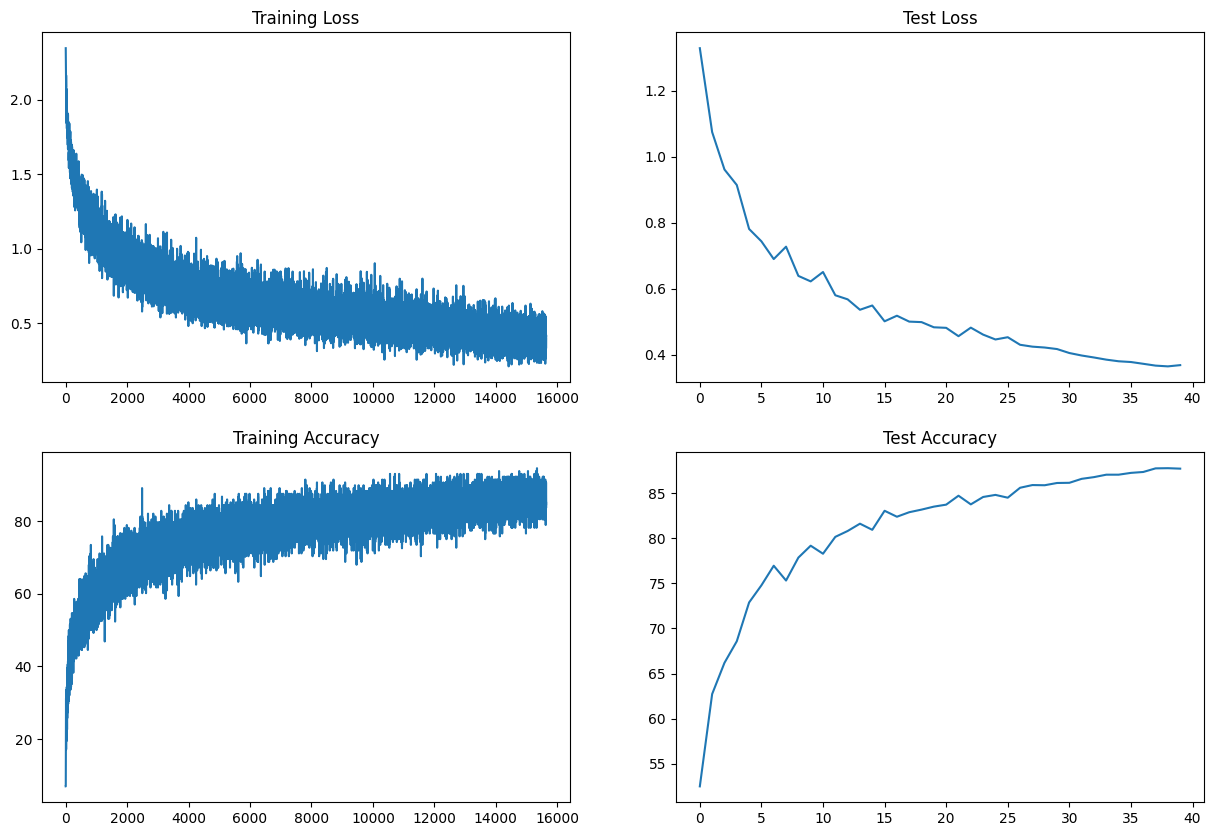

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")